# Segmenting and Clustering Neighbourhoods in Toronto

## Part 1 - Get postcodes for Toronto neighbourhoods
### Import Pandas and Numpy libraries
* The cell below assumes pandas and numpy are available to the Jupyter process.
* If this is false, the cell will fail to execute and the user will need to install these libraries.

In [1]:
#Import pandas and numpy
import pandas as pd
import numpy as np

### Extract and format postcodes from Wikipedia page
This assumes the Wikipedia page has a table with exactly three columns, including one starting with:
* "Postcode" for postcodes
* "Borough" for borough
* "Neighbourhood" for neighbourhood

The logic will need updating if the format of the Wikipedia page changes.

In [2]:
#Get all tables from Wikipedia page in "tables"
tables=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

#Get "postcodes" table
for table in tables:
    if table.columns.size == 3:
        if table.columns[0] == 'Postcode':
            if table.columns[1] == 'Borough':
                if table.columns[2] == 'Neighbourhood':
                    postcodes = table

#free redundant variables
del table
del tables

#Rename Postcode column to PostalCode
postcodes.rename(columns={'Postcode': 'PostalCode'}, inplace=True)

#Remove 'Not assigned' borough records
postcodes=postcodes[postcodes.Borough != 'Not assigned']

#Set Neighbourhood to Borough where Neighbourhood is not assigned.
postcodes.Neighbourhood = np.where(postcodes.Neighbourhood == 'Not assigned',postcodes.Borough,postcodes.Neighbourhood)

#Join strings for PostalCode has more than one Neighbourhood
postcodes=postcodes.groupby(['PostalCode','Borough']).Neighbourhood.unique().reset_index()
postcodes.Neighbourhood = postcodes.Neighbourhood.str.join(', ')

#Print postcodes
postcodes

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."


### Print shape of postcodes data

In [3]:
#Print postcodes shape
postcodes.shape

(103, 3)

## Part 2 - Get latitude and longitude (geocodes)
### Load geocode data
This code assumes there is a CSV file https://cocl.us/Geospatial_data with the geocode data that:
* contains exactly three columns
* that the columns have the headings "Postal Code", "Latitude" and "Longitude"
* that the heading correctly identify the fields.

The code will need updating if these assumptions become invalid.

In [4]:
#Get geocodes
geocodes=pd.read_csv('https://cocl.us/Geospatial_data')

#Regularise column name (as per assignment)
geocodes.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

#Print postcodes
geocodes

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


### Print shape of geocodes data

In [5]:
#Print geocodes shape
geocodes.shape

(103, 3)

The shape (103, 3) indicates one row for each neighbourhood.
### Merge the geocodes and postcode tables
This code assumes the field PostCode has a common encoding for each table.

In [6]:
#Left join "geocodes" to "postcode" table
postcodes_geocodes = pd.merge(postcodes, geocodes, how='left')

#Free redundant variables
del postcodes
del geocodes

#Print geocodes_postcodes
postcodes_geocodes

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


### Print the shape of the post_codes table

In [7]:
#Print postcodes_geocodes shape
postcodes_geocodes.shape

(103, 5)

## Part 3 - Analyse Toronto neighbourhood data

### Import libraries and functions

* This code assumes the libraries are available to the Jupyter process hosting the notebook.
* If they are not available, executing the Notebook will fail.

In [8]:
from geopy.geocoders import Nominatim
import folium
import os

### Get Toronto's longitude and latitude

In [9]:
geolocator = Nominatim(user_agent='toronto_explorer')
location = geolocator.geocode('Toronto, Canada')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create a map of Toronto

In [10]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

### Add Neighbourhood geocodes to Toronto map

In [11]:
# add markers to map
for lat, lng, label in zip(postcodes_geocodes['Latitude'], postcodes_geocodes['Longitude'], postcodes_geocodes['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Get Foursquare details

In [12]:
#Read Foursquare details environment variables.
CLIENT_ID = os.environ['FOURSQUARE_ID']
CLIENT_SECRET = os.environ['FOURSQUARE_SECRET']

#Set version to API as 5 June 2018.
VERSION = '20180605' # Foursquare API version

### Import requests library
* The code assumes requests is available to the Jupyter process.
* If not, the code will fail and the user will need to install the library.

In [13]:
import requests

### Create function to get nearby venues
The code assumes:
* the Foursquare details are correct (there is no error handling)
* the Foursquare API version is still supported
* the user has not exhausted their query allowance.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get venues for all neighbourhoods
* The code will take a long time to run, due to Foursquare queries.
* The code assumes the user has not exhausted their Foursquare query allowance.

In [15]:
toronto_venues = getNearbyVenues(names=postcodes_geocodes['Neighbourhood'],
                                   latitudes=postcodes_geocodes['Latitude'],
                                   longitudes=postcodes_geocodes['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

### Check toronto_venues shape

In [16]:
toronto_venues.shape

(2234, 7)

### Check top five rows of toronto_venues

In [17]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


### Count the venues by neighbourhood

In [18]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",7,7,7,7,7,7
"Alderwood, Long Branch",9,9,9,9,9,9
...,...,...,...,...,...,...
Willowdale West,7,7,7,7,7,7
Woburn,3,3,3,3,3,3
"Woodbine Gardens, Parkview Hill",13,13,13,13,13,13


### Check number of unique categories received

In [19]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 275 uniques categories.


### Transform venue data to one-hot encoding by venue category

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Print shape of toronto_onehot

In [21]:
toronto_onehot.shape

(2234, 275)

### Aggregate venue resulting using mean by neighbour

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
95,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
96,"Woodbine Gardens, Parkview Hill",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
97,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.1,0.0,0.0,0.00,0.0,0.0,0.0


### Print shape of toronto_grouped

In [23]:
toronto_grouped.shape

(99, 275)

### Print top five venues by suburb

In [24]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.07
1             Café  0.05
2              Bar  0.04
3       Steakhouse  0.04
4  Thai Restaurant  0.04


----Agincourt----
                       venue  freq
0                     Lounge  0.25
1             Breakfast Spot  0.25
2  Latin American Restaurant  0.25
3               Skating Rink  0.25
4                Yoga Studio  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                venue  freq
0          Playground  0.33
1                 Gym  0.33
2                Park  0.33
3         Yoga Studio  0.00
4  Mexican Restaurant  0.00


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                 venue  freq
0          Pizza Place  0.14
1        Grocery Store  0.14
2             Pharmacy  0.14
3           Beer Store  0.14
4  Fried Chicken Joint  0.14


----Alderwood, Long Branch----
                venue  fr

                 venue  freq
0   Mexican Restaurant  0.25
1     Sushi Restaurant  0.25
2                Trail  0.25
3        Jewelry Store  0.25
4  Monument / Landmark  0.00


----Glencairn----
                 venue  freq
0           Playground   0.2
1  Japanese Restaurant   0.2
2               Bakery   0.2
3                 Park   0.2
4                  Pub   0.2


----Guildwood, Morningside, West Hill----
                 venue  freq
0          Pizza Place  0.12
1  Rental Car Location  0.12
2                  Spa  0.12
3       Breakfast Spot  0.12
4       Medical Center  0.12


----Harbord, University of Toronto----
                venue  freq
0                Café  0.17
1              Bakery  0.06
2  Italian Restaurant  0.06
3           Bookstore  0.06
4      Sandwich Place  0.06


----Harbourfront----
            venue  freq
0     Coffee Shop  0.15
1            Park  0.06
2          Bakery  0.06
3             Pub  0.06
4  Breakfast Spot  0.04


----Harbourfront East, Toronto Islan

### Define function to get most common venues

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Get top 10 venues for each neighbourhood

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Thai Restaurant,Restaurant,American Restaurant,Sushi Restaurant,Asian Restaurant,Bakery
1,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Gym,Playground,Park,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pharmacy,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Pizza Place,Sandwich Place,Grocery Store,Airport Lounge,Afghan Restaurant,Falafel Restaurant
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Athletics & Sports,Pharmacy,Pub,Sandwich Place,Skating Rink,Gym,Airport Service,Dessert Shop


### Import KMeans and pyplot
This code assumes these libraries are available. Otherwise, it will fail and the user will need to install them.

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Drop neighbourhood to prepare data for k-means

In [28]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

### Find the best k using the elbow method

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

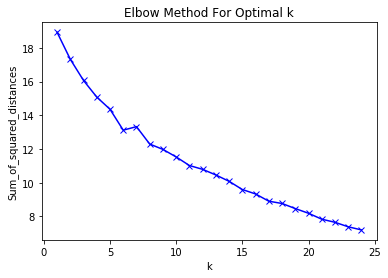

In [29]:
Sum_of_squared_distances = []

K = range(1,25)

for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')

plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

plt

### Set the best k and re-run k-means
Six looks like the best k, using the elbow method

In [30]:
# Set the best k to be the number of clusters.
best_k = 6

# Re-run k-means
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(toronto_grouped_clustering)

### Add cluster labels to neighbourhoods_venues_sorted dataframe

In [31]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

### Join neighbourhoods_venues_sorted to toronto_merged

In [32]:
toronto_merged = postcodes_geocodes
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
toronto_merged.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2.0,Fast Food Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,College Rec Center
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0.0,Moving Target,Bar,Women's Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Electronics Store,Pizza Place,Spa,Breakfast Spot,Rental Car Location,Intersection,Mexican Restaurant,Medical Center,Women's Store,Doner Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean Restaurant,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Hakka Restaurant,Gas Station,Athletics & Sports,Bakery,Caribbean Restaurant,Thai Restaurant,Bank,Fried Chicken Joint,Drugstore,Donut Shop


### Import isnan, cm and colors
This code assumes these libraries are available. If not, it will fail.

In [33]:
from matplotlib import cm, colors
from math import isnan

### Add cluster colouring to map

In [34]:
# Create new map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set the colour scheme for the clusters
x = np.arange(best_k)
ys = [i + x + (i*x)**2 for i in range(best_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add coloured markers to the new map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if isnan(cluster) == False:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)],
            fill=True,
            fill_color=rainbow[int(cluster)],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Check cluster 0

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,0.0,Moving Target,Bar,Women's Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,Scarborough,0.0,Electronics Store,Pizza Place,Spa,Breakfast Spot,Rental Car Location,Intersection,Mexican Restaurant,Medical Center,Women's Store,Doner Restaurant
3,Scarborough,0.0,Coffee Shop,Korean Restaurant,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,Scarborough,0.0,Hakka Restaurant,Gas Station,Athletics & Sports,Bakery,Caribbean Restaurant,Thai Restaurant,Bank,Fried Chicken Joint,Drugstore,Donut Shop
5,Scarborough,0.0,Women's Store,Playground,Business Service,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dessert Shop,Drugstore
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Etobicoke,0.0,Pharmacy,Beer Store,Pizza Place,Coffee Shop,Convenience Store,Café,Liquor Store,German Restaurant,General Travel,Electronics Store
96,North York,0.0,Pizza Place,Empanada Restaurant,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
99,Etobicoke,0.0,Pizza Place,Chinese Restaurant,Intersection,Sandwich Place,Coffee Shop,Discount Store,Middle Eastern Restaurant,Women's Store,Dog Run,Doner Restaurant
101,Etobicoke,0.0,Pharmacy,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Pizza Place,Sandwich Place,Grocery Store,Airport Lounge,Afghan Restaurant,Falafel Restaurant


### Check cluster 1

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,North York,1.0,Cafeteria,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Fast Food Restaurant


### Check cluster 2

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,2.0,Fast Food Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,College Rec Center


### Check cluster 3

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,3.0,Garden,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Women's Store,Dessert Shop


### Check cluster 4

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,4.0,Gym,Playground,Park,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
23,North York,4.0,Park,Bank,Convenience Store,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
25,North York,4.0,Park,Food & Drink Shop,Women's Store,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
30,North York,4.0,Airport,Park,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
44,Central Toronto,4.0,Park,Swim School,Bus Line,Women's Store,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
50,Downtown Toronto,4.0,Park,Playground,Trail,Women's Store,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
74,York,4.0,Park,Women's Store,Market,Fast Food Restaurant,Gourmet Shop,Event Space,Greek Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant
79,North York,4.0,Park,Bakery,Construction & Landscaping,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
90,Etobicoke,4.0,Park,River,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
100,Etobicoke,4.0,Pizza Place,Mobile Phone Shop,Park,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore


### Check cluster 5

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,5.0,Baseball Field,Locksmith,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dim Sum Restaurant
97,North York,5.0,Baseball Field,Women's Store,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Dim Sum Restaurant


# Observations
From a k-means cluster analysis with a k of six, shows:
* in all, the analysis considered 275 postcodes
* 85 (30.9%) of postcodes were in cluster 0, with:
 * many types of resturants, retail stores and health services
 * limited outdoor spaces
 * a geographic concentration in inner Toronto and regional centres
* 10 (3.6%) of postcodes were in cluster 4, with:
 * a geographic spread mostly in outer Toronto
 * strong availability of outdoor spaces
 * good availability of resturants and drug stores
* clusters 1, 2, 3, 5 had low numbers of members, with:
 * cluster 1 with 1 postcodes (<0.1%)
 * cluster 2 with 1 postcodes (<0.1%)
 * cluster 3 with 1 postcodes (<0.1%)
 * cluster 5 with 2 postcodes (<0.1%)
* clusters 1, 2, 3 and 5 effectively represent outliers
* 175 postcodes were missing from the results, due to no data from Foursquare.

There should be follow-up research to examine more complete data sources and determine a use case for the analysis.
